In [2]:
import torch 
import torch.nn as nn
from torch.optim.lr_scheduler import MultiStepLR

import os
import time
import numpy as np
import matplotlib.pyplot as plt

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"

seed = 0
folder = 'cgdpo_incomplete'
if not os.path.exists(folder) :
    os.mkdir(folder)

torch.set_printoptions(sci_mode=False,precision=4)
np.set_printoptions(suppress=True,precision=4,linewidth=100)

In [4]:
mu = 0.12
r = 0.03
vol = 0.2
gamma = 2.

kappa_y = 1.
theta_y = (mu-r)/vol
vol_y = 0.5
rho_y = 0.5

m = 20
n = int(1e6)

T_max = 5.
W_min = 1e-1
W_max = 3.
Y_min = -5.*theta_y
Y_max = +5.*theta_y

lb_w = 1e-4
lb_y = -20*theta_y
ub_y = +20*theta_y

In [5]:
class MyopicNet(nn.Module) :
 
    def __init__(self) :
        super(MyopicNet,self).__init__()
        
        self.linear1a = nn.Linear(1,200)
        self.linear2a = nn.Linear(200,200)
        self.linear3a = nn.Linear(200,200)
        self.linear4a = nn.Linear(200,1)
       
        self.F = nn.LeakyReLU()
        self.H = nn.Softplus()
        
    def forward(self,x0) :

        xa = x0
        
        xa = self.linear1a(xa)
        xa = self.F(xa)
        xa = self.linear2a(xa)
        xa = self.F(xa)
        xa = self.linear3a(xa)
        xa = self.F(xa)
        xa = self.linear4a(xa)

        return xa.squeeze()

In [6]:
class HedgingNet(nn.Module) :

     def __init__(self) :
        super(HedgingNet,self).__init__()

        self.linear1a = nn.Linear(3,200)
        self.linear2a = nn.Linear(200,400)
        self.linear3a = nn.Linear(400,200)
        self.linear4a = nn.Linear(200,1)

        self.F = nn.ReLU()
        self.H = nn.Softplus()
         
     def forward(self,x0) :

        xa = x0 
        xa = self.linear1a(xa)
        xa = self.F(xa)
        xa = self.linear2a(xa)
        xa = self.F(xa)
        xa = self.linear3a(xa)
        xa = self.F(xa)
        xa = self.linear4a(xa)

        xa = xa * x0[:,1:2] 
        xa = torch.tanh(xa)
        return xa.squeeze() 

In [7]:
torch.manual_seed(seed)
np.random.seed(seed)

net_m = MyopicNet()
net_m = net_m.cuda() 
opt_m = torch.optim.Adam(net_m.parameters(),lr=1e-3)

net_h = HedgingNet()
net_h = net_h.cuda() 
opt_h = torch.optim.Adam(net_h.parameters(),lr=1e-5)

In [9]:
def generate_uniform_domain(n) :
    
    T = T_max*torch.rand([int(n)]).cuda()
    dt = T/m

    W = W_min + (W_max - W_min)*torch.rand([n]).cuda()
    Y = Y_min + (Y_max-Y_min)*torch.rand([n]).cuda()

    return T,W,Y,dt

In [10]:
def get_A_B_C(t) :
    
    GAMMA = 1./gamma
    a = GAMMA - 1.
    b = 2.*((GAMMA-1.)*rho_y*vol_y-kappa_y)
    c = vol_y**2*(1.+(GAMMA-1.)*rho_y**2)
    q = b**2 - 4*a*c
    eta = np.sqrt(q)
    
    C1 = 2.*(GAMMA-1.)*(1.-np.exp(-eta*t))
    C2 = 2.*eta - (b+eta)*(1.-np.exp(-eta*t))
    C = C1/C2

    B1 = 4.*(GAMMA-1.)*kappa_y*theta_y*(1.-np.exp(-eta*t/2.))**2
    B2 = eta*( 2.*eta - (b+eta)*(1.-np.exp(-eta*t)) )
    B = B1/B2

    A1 = (GAMMA-1.)*( 2.*kappa_y**2*theta_y**2/eta**2 + vol_y**2/(eta-b) )*t
    A2 = 4.*(GAMMA-1.)*kappa_y**2*theta_y**2 * ( (2.*b+eta)*np.exp(-eta*t) - 4.*b*np.exp(-eta*t/2.) + 2.*b - eta )
    A3 = eta**3 * (2.*eta-(b+eta)*(1.-np.exp(-eta*t)))
    A4 = 2.*(GAMMA-.1)*vol_y**2/(eta**2-b**2) * np.log( (2.*eta-(b+eta)*(1.-np.exp(-eta*t)))/(2.*eta) )
    A = A1 + A2/A3 + A4
    
    return A,B,C

def get_weight(x, t, y) :
    GAMMA = 1./gamma
    A,B,C = get_A_B_C(t)
    
    myopic_term = GAMMA*(y/vol)*x
    hedging_term = GAMMA*(rho_y*vol_y*C*(y/vol) + rho_y*vol_y*B/vol)*x
    return myopic_term,hedging_term

In [14]:
import torch.autograd.functional as F

def measure(xx) :

    xx.requires_grad = True

    a_m = net_m(xx[:,2:3])
    a_h = net_h(xx)    
    a_w = a_m + a_h
    
    grad_outputs = torch.ones_like(a_w) 
    d1 = torch.autograd.grad(a_w, xx, grad_outputs=grad_outputs, create_graph=True)[0]
    d11 = torch.autograd.grad(d1[:,0], xx, grad_outputs=grad_outputs, create_graph=True)[0][:,0:1].detach()
    d22 = torch.autograd.grad(d1[:,1], xx, grad_outputs=grad_outputs, create_graph=True)[0][:,1:2].detach()
    d33 = torch.autograd.grad(d1[:,2], xx, grad_outputs=grad_outputs, create_graph=True)[0][:,2:3].detach()

    d11 = torch.sqrt(d11**2/torch.sum(d11**2))
    d22 = torch.sqrt(d22**2/torch.sum(d22**2))
    d33 = torch.sqrt(d33**2/torch.sum(d33**2))
    
    d2 = torch.cat([d11,d22,d33],axis=1).detach()
    xx.requires_grad = False
    
    std = torch.sum(d2**2,axis=1,keepdims=True)

    return std

def weighted_sampling_torch(vector, num_samples):
    tensor = torch.tensor(vector, dtype=torch.float)
    weights = torch.linspace(1, 0.1, len(vector))**2
    probabilities = weights / weights.sum()
    sampled_indices = torch.multinomial(probabilities, num_samples, replacement=False)
    samples = tensor[sampled_indices].tolist()
    return samples

def generate_domain_adaptive_sampling(n,y0=None) :

    T,W,Y,dt = generate_uniform_domain(5*n)
    
    xx = torch.rand([5*n,3]).cuda()
    xx[:,0] = W
    xx[:,1] = T
    if y0 == None :
        xx[:,2] = Y
    else :
        xx[:,2] = y0
    xx = xx.cuda()

    std = measure(xx)
    W = W.reshape(-1)
    T = T.reshape(-1)
    Y = Y.reshape(-1)
    std = std.reshape(-1)

    idx = torch.argsort(std,descending=True)
    n_sample = int(0.9*n)
    sample = weighted_sampling_torch(torch.arange(len(idx)).cuda(), n_sample)
    W2 = W[idx][sample]
    T2 = T[idx][sample]
    Y2 = Y[idx][sample]
    
    T1 = T_max*torch.rand([n-n_sample]).cuda()
    T = torch.hstack([T1,T2])
    dt = T/m
    
    W1 = W_min + (W_max-W_min)*torch.rand([n-n_sample]).cuda()
    W = torch.hstack([W1,W2])

    Y1 = Y_min + (Y_max-Y_min)*torch.rand([n-n_sample]).cuda()
    Y = torch.hstack([Y1,Y2])

    return T,W,Y,dt

In [15]:
def plot(iter,min,save,y0,U,case,lr_m,lr_h) :

    np.random.seed(seed)
    torch.manual_seed(seed)

    if not save :
        iter = -1

    def draw(x,t,u,filename) :
        
        tmp = u
        tmp = np.sort(tmp)
        m = 100
        n = (len(tmp)-1)//m
        levels = [tmp[i*n] for i in range(m+1)]
        levels[-1] = tmp[-1]
    
        color_map = plt.cm.jet
        colors = color_map(np.linspace(0, 1, m+1))
    
        plt.figure(figsize=(6.5,5))
        plt.plot(x, t, 'o', markersize=0.5, alpha=0.5, color='grey')
        try :
            contourf_plot = plt.tricontourf(x,t,u,levels=levels,colors=colors)
        except :
            contourf_plot = plt.tricontourf(x,t,u)
        plt.xlabel('W')
        plt.ylabel('T-t')
        plt.colorbar(contourf_plot)

        plt.savefig(filename)
        plt.close()

    # ************************************************************************************************** #

    T,W,Y,dt = generate_domain_adaptive_sampling(10000,y0)

    xx = torch.rand([10000,3]).cuda()
    xx[:,0] = W
    xx[:,1] = T
    xx[:,2] = Y
    xx = xx.cuda()

    std = measure(xx)
    x = xx[:,0].clone().cpu().numpy()
    t = xx[:,1].clone().cpu().numpy()
    std = std.detach().cpu().numpy()

    plt.figure(figsize=(5.2,5.2))
    plt.plot(x, t, 'o', markersize=0.5, alpha=0.5, color='grey')
    plt.xlabel('W'); plt.xlim([0,W_max])
    plt.ylabel('T-t'); plt.ylim([0,T_max])
    plt.grid()
    plt.savefig('%s/sampling_points_case_%d_iter_%d.png'%(folder,case,iter))
    plt.close()

    # ************************************************************************************************** #
    
    xx = torch.rand([10000,1]).cuda()
    xx[:,0] = y0
    xx = xx.cuda()
    
    with torch.no_grad() :
        a_m = net_m(xx)

    W,T,_,_ = generate_uniform_domain(10000)
    
    xx = torch.rand([10000,3]).cuda()
    xx[:,0] = W
    xx[:,1] = T
    xx[:,2] = y0
    xx = xx.cuda()

    with torch.no_grad() :
        a_h = net_h(xx)
        
    x = xx[:,0].clone().cpu().numpy()
    t = xx[:,1].clone().cpu().numpy()
    a_m = a_m.detach().cpu().numpy()
    a_h = a_h.detach().cpu().numpy()

    a_m = a_m*x
    a_h = a_h*x
    
    m_sol,h_sol = get_weight(x,t,y0)
    a_w = a_m+a_h; w_sol = m_sol+h_sol
            
    draw(x,t,a_m,'%s/m_net_case_%d_iter_%d.png'%(folder,case,iter))
    draw(x,t,m_sol,'%s/m_sol_case_%d_iter_%d.png'%(folder,case,iter))
    draw(x,t,a_m-m_sol,'%s/m_err_case_%d_iter_%d.png'%(folder,case,iter))
    tmp = a_m-m_sol
    err_m = np.sqrt( np.mean(tmp**2/m_sol**2) )

    draw(x,t,a_h,'%s/h_net_case_%d_iter_%d.png'%(folder,case,iter))
    draw(x,t,h_sol,'%s/h_sol_case_%d_iter_%d.png'%(folder,case,iter))
    draw(x,t,a_h-h_sol,'%s/h_err_case_%d_iter_%d.png'%(folder,case,iter))
    tmp = a_h-h_sol
    err_h = np.sqrt( np.mean(tmp**2/h_sol**2) )

    draw(x,t,a_w,'%s/w_net_case_%d_iter_%d.png'%(folder,case,iter))
    draw(x,t,w_sol,'%s/w_sol_case_%d_iter_%d.png'%(folder,case,iter))
    draw(x,t,a_w-w_sol,'%s/w_err_case_%d_iter_%d.png'%(folder,case,iter))
    tmp = a_w-w_sol
    err_w = np.sqrt( np.mean(tmp**2/w_sol**2) )

    with open('%s/errs_case_%d_iter_%d.txt'%(folder,case,iter),'wt') as f : 
        print("i: %d  min: %d  err_m: %10.6e  err_h: %10.6e  err_w: %10.6e  U: %10.6e  lr_m: %10.3e  lr_h: %10.3e"%(i,min,err_m,err_h,err_w,U,lr_m,lr_h),file=f)

In [17]:
i = 0
min = 0
lr_m = opt_m.param_groups[0]['lr']
lr_h = opt_h.param_groups[0]['lr']
plot(i,min,False,0.5*theta_y,0,-1,lr_m,lr_h)
plot(i,min,False,1.0*theta_y,1,-1,lr_m,lr_h)
plot(i,min,False,2.0*theta_y,2,-1,lr_m,lr_h)

/tmp/ipykernel_1317073/415137908.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(vector, dtype=torch.float)


/tmp/ipykernel_1317073/415137908.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor = torch.tensor(vector, dtype=torch.float)


current_min:     0  target_min:     1  last_min:   480


KeyboardInterrupt: 

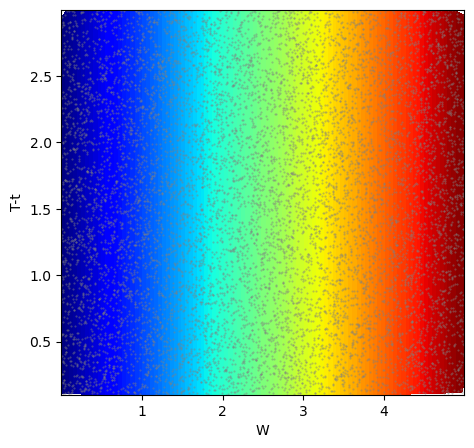

In [18]:
mins = np.array([1,5,10,30,60*1,60*2,60*4,60*8])

torch.manual_seed(seed)
np.random.seed(seed)

def lr_lambda(epoch):
    if epoch > 100 : return 0.1
    else :           return 1

net_m = MyopicNet()
net_m = net_m.cuda() 
net_m = nn.DataParallel(net_m) ##
opt_m = torch.optim.Adam(net_m.parameters(),lr=1e-3)
sch_m = torch.optim.lr_scheduler.LambdaLR(opt_m,lr_lambda)

net_h = HedgingNet()
net_h = net_h.cuda() 
net_h = nn.DataParallel(net_h) ##
opt_h = torch.optim.Adam(net_h.parameters(),lr=1e-5)    
sch_h = torch.optim.lr_scheduler.LambdaLR(opt_h,lr_lambda)

flag_write = False
flag_draw = False
flag_exit = False
i = 0; mins_idx = 0
start_time = time.time()
start_time_draw = time.time()
draw_time = 0.

while True :

    # ************************************************************************************************** #

    opt_m.zero_grad()
    opt_h.zero_grad()

    T,W,Y,dt = generate_domain_adaptive_sampling(n)

    for k in range(m) :
        t = k*dt

        state = torch.vstack([Y]).T
        a_m = net_m(state)

        state = torch.vstack([W,T-t,Y]).T
        a_h = net_h(state)     
        
        pi = a_m + a_h
        
        dZ = torch.randn([n]).cuda()*torch.sqrt(dt)
        dZ_y = torch.randn([n]).cuda()*torch.sqrt(dt)
        dZ_y = rho_y*dZ + np.sqrt(1.-rho_y**2)*dZ_y
        W = W*torch.exp( ( r + Y*vol*pi - 0.5*vol**2*pi**2 )*dt + vol*pi*dZ )
        W = torch.relu(W - lb_w) + lb_w
        
        Y = Y + kappa_y*(theta_y-Y)*dt + vol_y*dZ_y
        Y = torch.relu(Y - lb_y) + lb_y
        Y = -torch.relu(ub_y - Y) + ub_y
        
    t = T
    U = W**(1-gamma)/(1-gamma)     
    U = -U.nanmean()
    U.backward()
   
    max_norm = 0.01
    torch.nn.utils.clip_grad_norm_(net_m.parameters(), max_norm)
    torch.nn.utils.clip_grad_norm_(net_h.parameters(), max_norm)

    elapsed_time = time.time() - start_time - draw_time

    opt_m.step()
    sch_m.step()
    if elapsed_time > 60*5 :
        opt_h.step()
        sch_h.step()

    # ************************************************************************************************** #
    
    time_i = time.time()
    elapsed_time = time_i - start_time - draw_time
    current_min = int(elapsed_time//60)
    elapsed_time_draw = time_i - start_time_draw
    
    target_min = mins[mins_idx]
    current_set_time = 60*target_min
    last_set_time = 60*mins[-1]
    
    if elapsed_time_draw > 60*3 : 
        start_time_draw = time.time()
        flag_draw = True
    
    if elapsed_time > current_set_time : 
        flag_write = True
        mins_idx = mins_idx + 1
        
    if elapsed_time > last_set_time :
        flag_exit = True   

    lr_m = opt_m.param_groups[0]['lr']
    lr_h = opt_h.param_groups[0]['lr']

    if not flag_write :
        if flag_draw or i == 0 :
            print('current_min: %5d  target_min: %5d  last_min: %5d'%(current_min,target_min,mins[-1]))
            plot(i,current_min,False,0.5*theta_y,U,0,lr_m,lr_h)
            plot(i,current_min,False,1.0*theta_y,U,0,lr_m,lr_h)
            plot(i,current_min,False,1.0*theta_y,U,0,lr_m,lr_h)
            flag_draw = False
        
    elif flag_write :
        print('current_min: %5d  target_min: %5d  last_min: %5d'%(current_min,target_min,mins[-1]),'-->','saved')
        plot(i,current_min,True,0.5*theta_y,U,0,lr_m,lr_h)
        plot(i,current_min,True,1.0*theta_y,U,0,lr_m,lr_h)
        plot(i,current_min,True,1.0*theta_y,U,0,lr_m,lr_h)
        flag_write = False

    draw_time = draw_time + (time.time() - time_i)

    if flag_exit : break
    i = i+1           

print('finished')